In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# VGG-19 for CIFAR-10 Dataset

This notebook implements a VGG-19 convolutional neural network to classify the CIFAR-10 dataset.

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


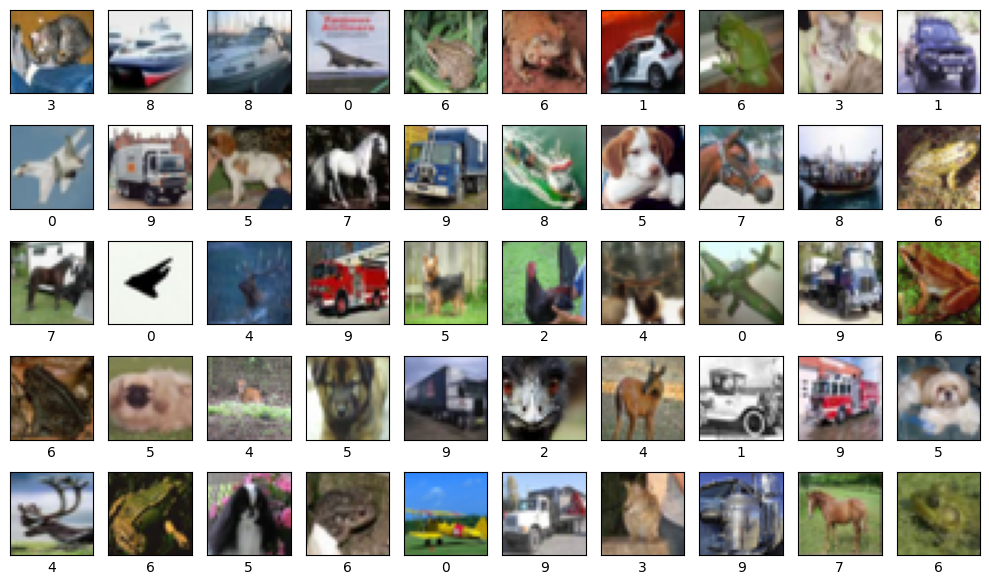

In [3]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [4]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [5]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


In [6]:
# Define VGG-19 architecture for CIFAR-10
def build_vgg19_model(input_shape=(32, 32, 3), num_classes=10):
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten and Dense layers
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu', name='fc3')(x)  # Added 1000-neuron dense layer
    x = Dropout(0.5)(x)  # Added dropout for the new layer
    output_layer = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19')
    return model

# Build the model
vgg19_model = build_vgg19_model(input_shape=(32, 32, 3), num_classes=10)

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Print model summary
vgg19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 43,013,954 (164.09 MB)

 Trainable params: 43,013,954 (164.09 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_cifar10_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [8]:
# Train the model
print("\nTraining VGG-19 model...")
batch_size = 32
epochs = 100

history = vgg19_model.fit(
    X_train_norm, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)


Training VGG-19 model...
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1017 - loss: 2.3065

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 75ms/step - accuracy: 0.1017 - loss: 2.3065 - val_accuracy: 0.0973 - val_loss: 2.3033 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0993 - loss: 2.3029

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 129s 72ms/step - accuracy: 0.0993 - loss: 2.3029 - val_accuracy: 0.1015 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 131s 64ms/step - accuracy: 0.1004 - loss: 2.3028 - val_accuracy: 0.0979 - val_loss: 2.3027 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.1004 - loss: 2.3028 - val_accuracy: 0.1015 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.0994 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3029 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.0986 - loss: 2.3027 - val_accuracy: 0.0933 - val_loss: 2.3029 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - accuracy: 0.1026 - loss: 2.3026 - val_accuracy: 0.0973 - val_loss: 2.3028 - learning_rate: 0.0010
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 63ms/step - accuracy:

In [9]:
# Evaluate the model on training, validation, and test sets
train_scores = vgg19_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = vgg19_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = vgg19_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 2.3026, Train Accuracy: 9.96%
Validation Loss: 2.3027, Validation Accuracy: 10.15%
Test Loss: 2.3026, Test Accuracy: 10.00%


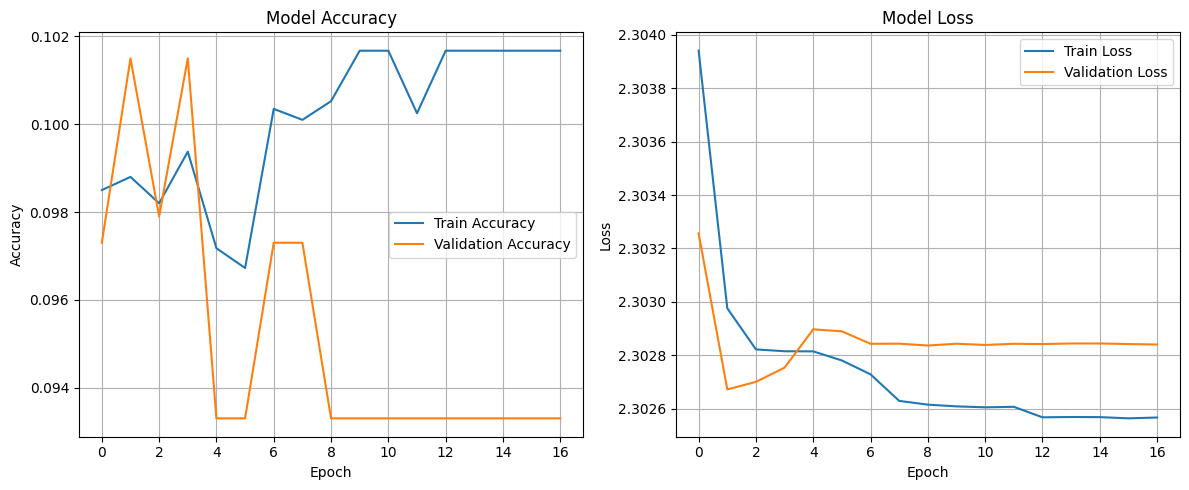

In [10]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


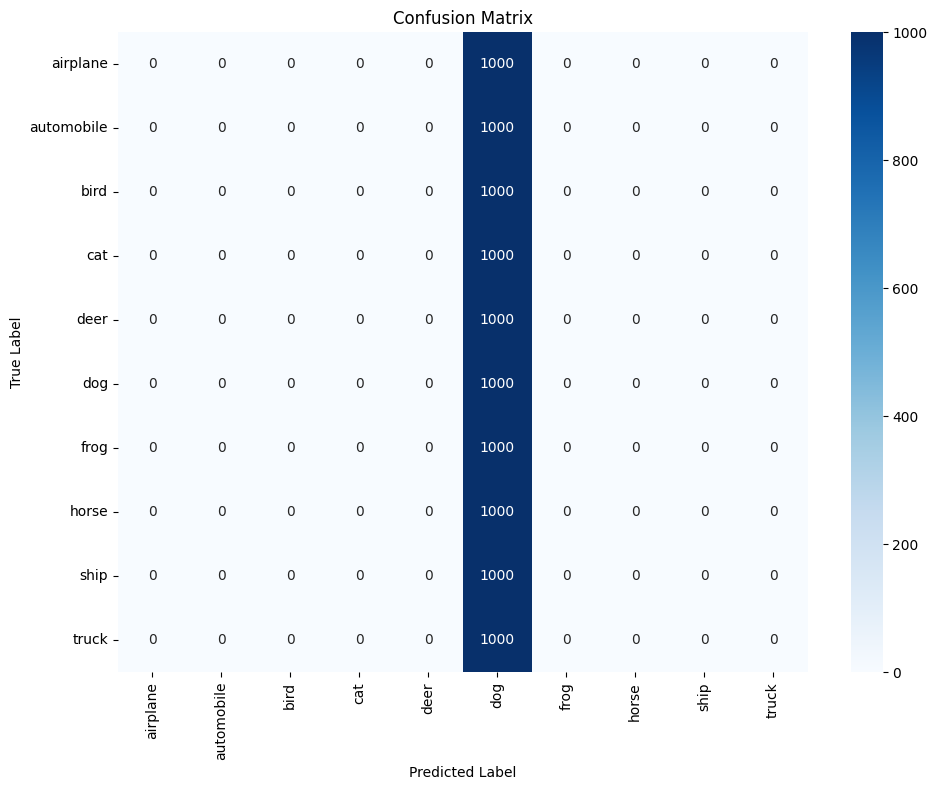


Classification Report:
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.10      1.00      0.18      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Make predictions on test set
y_pred = vgg19_model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

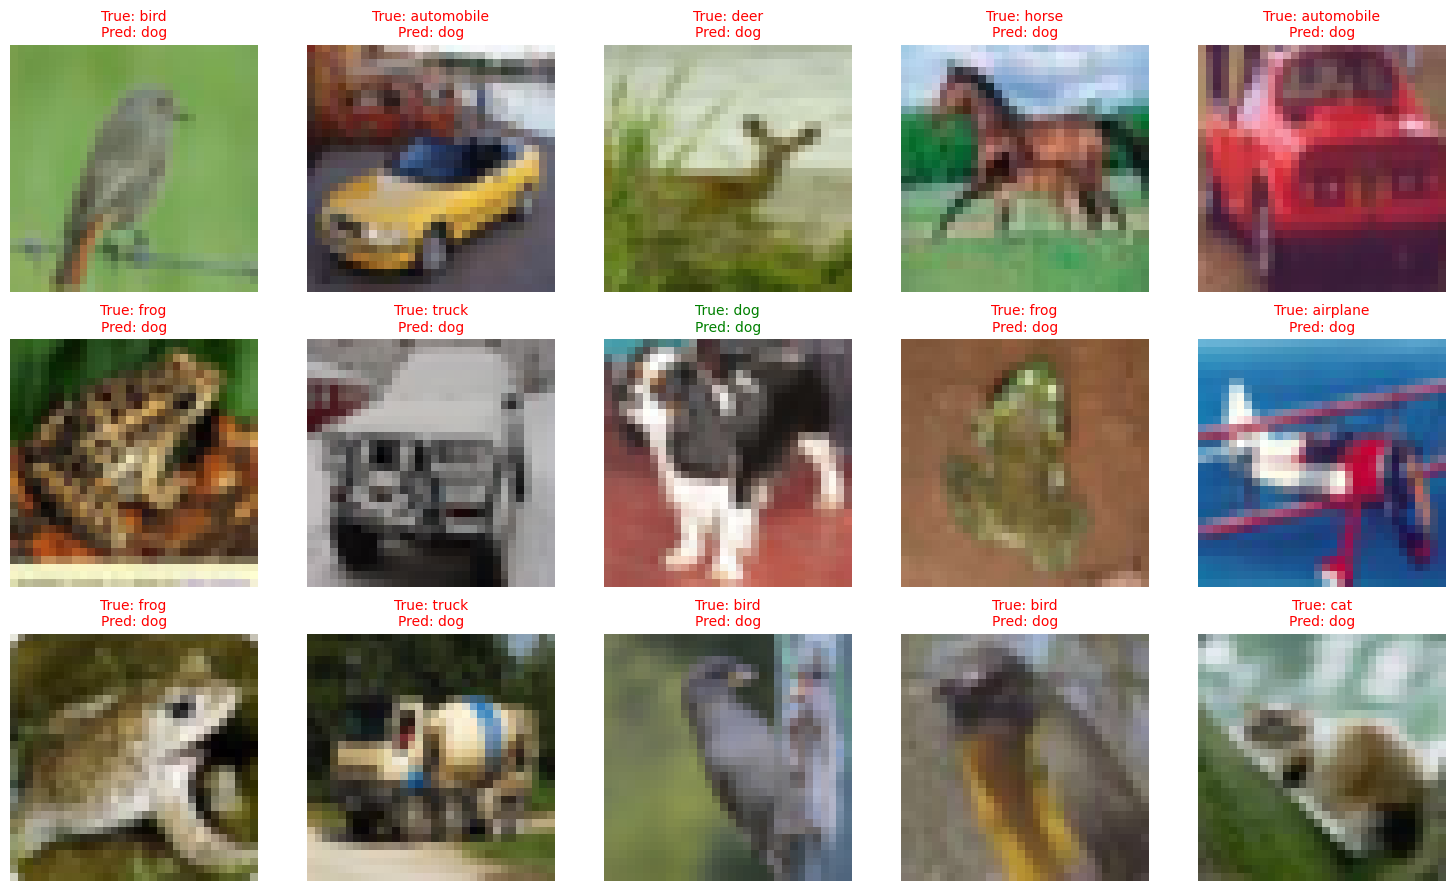

In [12]:
# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name = class_mapping.get(pred_label, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}",
                 fontsize=10, color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Save the final model
vgg19_model.save('vgg19_cifar10_final.h5')
print("Model saved successfully!")

Model saved successfully!
